# Severity Exploration

## Overview
In Part I, we set up a manufacturer with a loss structure (attritional, large, and catastrophic losses).
In Part II, we plot the true severity distribution and explore its shape.
In Part III, we draw a 5-year sample from the "true" distribution, and approximate it using Maximum Likelihood. The kicker is we have no significant catastrophic losses in the dataset, so we simulate an industry database of $5M+ catastrophic losses from a pool of around 10,000 companies per year (this annual number of companies is Poisson-distributed) and explore the catastrophic tail shape from that data.

- **Audience**: [Practitioner] / [Developer]

In [1]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import multiprocessing

warnings.filterwarnings("ignore")

from ergodic_insurance.pareto_frontier import (
    Objective, ObjectiveType, ParetoFrontier, ParetoPoint,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores: {N_CORES}")  # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

Number of CPU cores: 16


## Part I: Parameter Setup

### Manufacturing Company Configuration

Baseline company parameters (the experiment varies revenue via `revenue_grid`).

In [3]:
# --- Economic Parameters
ATR = 2.0                # Asset turnover ratio
OPERATING_MARGIN = 0.15  # 12% EBIT margin before Insurable Losses
REV_VOL = 0.50           # Revenue volatility (annualized)
INITIAL_ASSETS = 10_000_000

# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,          # $15M total assets
    asset_turnover_ratio=ATR,               # Revenue = Assets Ãƒâ€” turnover = $22.5M
    base_operating_margin=OPERATING_MARGIN, # 12% EBIT margin -> $2.7M/yr operating income
    tax_rate=0.25,                          # 25% corporate tax
    retention_ratio=0.70,                   # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>14.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {REV_VOL:>14}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

MANUFACTURING COMPANY PROFILE
Total Assets:          $    10,000,000
Annual Revenue:        $    20,000,000
Operating Income:      $     3,000,000
Operating Margin:               15.0%
Asset Turnover:                   2.0x
Revenue Volatility:               0.5
Tax Rate:                      25.0%
Retention Ratio:               70.0%


### Shared Simulation Infrastructure

Loss model, analytical LEV-based layer pricing, CRN scenario generation, and simulation engine.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import (
    ManufacturingLossGenerator, LognormalLoss, ParetoLoss,
)
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
REFERENCE_REVENUE = ATR * INITIAL_ASSETS  # Fixed reference for loss calibration

# --- Loss Scaling ---
# Loss frequency (and CRN loss amounts) scale with the square root of
# revenue.  This keeps the loss drag proportional to the company's
# actual size for both insured and uninsured strategies.
FREQ_SCALING_EXPONENT = 0.75

# --- Amplified Loss Model ---
ATTR_BASE_FREQ = 3
ATTR_SEV_MEAN = 10_000
ATTR_SEV_CV = 15

LG_BASE_FREQ = 1.25
LG_SEV_MEAN = 400_000
LG_SEV_CV = 7

CAT_BASE_FREQ = 0.15
CAT_SEV_ALPHA = 2.01
CAT_SEV_XM = 1_000_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ,
                        'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV,
                        'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ,
                  'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV,
                  'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                         'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM,
                         'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
SCENARIOS = 10_000
for _ in range(SCENARIOS):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation ({SCENARIOS:,.0f} one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Analytical Layer Pricing via LEV ---
# Instead of hardcoded rate-on-line values, we compute actuarially sound
# premiums from the known severity distributions using limited expected
# values (LEVs).  For each layer (attachment a, limit l):
#
#   E[layer loss] = sum_i  freq_i * [LEV_i(a+l) - LEV_i(a)]
#   premium       = E[layer loss] / target_loss_ratio
#   rate_on_line  = premium / limit
#
# This ensures the primary-layer ROL decreases naturally as the Ded
# (retention) rises, producing the genuine cost-vs-variance tradeoff
# that the HJB solver needs.
#
# The pricers are parameterized so that the sensitivity analysis (Part 9)
# can adapt premiums to match the modified loss assumptions being tested.

TARGET_LOSS_RATIO = 0.7  # Normal-market loss ratio
LOSS_RATIO_INFLECTION = 1  # Factor by which the max layer loss ratio differs from the base

def make_layer_pricers(large_freq=LG_BASE_FREQ,
                        large_sev_mean=LG_SEV_MEAN,
                        cur_revenue=REFERENCE_REVENUE) -> tuple:
    """Create a tuple of LayerPricers for a given loss parameterization.

    Frequency scales as (revenue / reference)^0.5, matching the loss
    model's sub-linear revenue scaling.  This keeps premium and loss
    scaling consistent so that insured and uninsured strategies face
    the same proportional cost growth.

    Args:
        large_freq: Large-loss annual frequency (default 1.0).
        large_sev_mean: Large-loss mean severity (default $1M).
        cur_revenue: Current revenue for frequency scaling.

    Returns:
        Tuple of (attritional, large, catastrophic) LayerPricers.
    """
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=large_sev_mean, cv=LG_SEV_CV),
                    frequency=large_freq * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


# Default pricers for baseline loss model
DEFAULT_PRICERS = make_layer_pricers()

MIN_LAYER_MIDPOINT = np.mean([0, 5_000_000])
MAX_LAYER_MIDPOINT = np.mean([450_000_000, 500_000_000])

def analytical_layer_premium(attachment: float, limit: float,
                            base_loss_ratio: float,
                            loss_ratio_inflection: float,
                            pricers=None) -> float:
    """Compute actuarial premium for a layer using LEV-based expected losses.

    Premium = E[layer loss] / layer_loss_ratio, where:
      E[layer loss] = sum over components of freq_i * (LEV_i(a+l) - LEV_i(a))

    Args:
        attachment: Layer attachment point.
        limit: Layer limit (width of coverage).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.
        base_loss_ratio: Desired loss ratio for the layer.
        loss_ratio_inflection: Factor by which the max layer loss ratio  differs from the base.
    """

    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    cur_layer_midpoint = np.mean([attachment, attachment + limit])
    layer_loss_ratio = base_loss_ratio + \
                        (1.0 / loss_ratio_inflection - 1.0) * base_loss_ratio \
                        * (cur_layer_midpoint - MIN_LAYER_MIDPOINT) \
                        / (MAX_LAYER_MIDPOINT - MIN_LAYER_MIDPOINT)
    return expected_loss / layer_loss_ratio


def analytical_rate_on_line(attachment: float, limit: float,
                            base_loss_ratio: float,
                            loss_ratio_inflection: float,
                            pricers=None) -> float:
    """Compute rate-on-line for a layer: premium / limit."""
    if limit <= 0:
        return 0.0
    return analytical_layer_premium(attachment,
                                    limit,
                                    base_loss_ratio,
                                    loss_ratio_inflection,
                                    pricers) / limit


# Validate: show how ROL varies across sample attachment points
print(f"\nAnalytical layer pricing (target LR = {TARGET_LOSS_RATIO:.0%}):")
print(f"  {'Attachment':>12s}  {'Limit':>12s}  {'E[Loss]':>12s}  {'Premium':>12s}  {'ROL':>8s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*8}")
for _a, _l in [(10_000, 4_990_000), (25_000, 4_975_000), (50_000, 4_950_000),
                (250_000, 4_750_000), (1_000_000, 4_000_000),
                (2_000_000, 3_000_000), (4_000_000, 1_000_000),
                (5_000_000, 20_000_000), (25_000_000, 25_000_000), (50_000_000, 50_000_000)]:
    _el = analytical_layer_premium(_a, _l, TARGET_LOSS_RATIO, 1.0) * TARGET_LOSS_RATIO
    _p = analytical_layer_premium(_a, _l, TARGET_LOSS_RATIO, 1.0)
    _r = analytical_rate_on_line(_a, _l, TARGET_LOSS_RATIO, 1.0)
    print(f"  ${_a:>11,.0f}  ${_l:>11,.0f}  ${_el:>11,.0f}  ${_p:>11,.0f}  {_r:>7.2%}")


# --- Insurance Tower Factory ---
# Premium rates are computed analytically from the loss distribution,
# ensuring that the primary-layer ROL decreases with higher retention.
# The optional `pricers` argument lets the sensitivity analysis pass
# in LayerPricers built from alternative loss assumptions, so that
# premiums stay consistent with the loss environment being tested.

def make_program(ded: float,
                base_loss_ratio: float,
                loss_ratio_inflection: float,
                max_limit: float,
                pricers=None) -> InsuranceProgram:
    """Create 4-layer tower with analytically priced premiums.

    Uses LEV-based layer pricing from severity distributions so that
    rate-on-line adjusts naturally with the retention level.

    Args:
        ded: Deductible.
        max_limit: Maximum coverage limit (top of tower).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.

    Returns:
        InsuranceProgram with actuarially sound premium loading.
    """
    layer_defs = [
        # (attachment, ceiling, reinstatements)
        (0, 5_000_000, 0),
        (5_000_000, 10_000_000, 0),
        (10_000_000, 25_000_000, 0),
        (25_000_000, 50_000_000, 0),
        (50_000_000, 100_000_000, 0),
        (100_000_000, 150_000_000, 0),
        (150_000_000, 200_000_000, 0),
        (200_000_000, 250_000_000, 0),
        (250_000_000, 300_000_000, 0),
        (300_000_000, 350_000_000, 0),
        (350_000_000, 400_000_000, 0),
        (400_000_000, 450_000_000, 0),
        (450_000_000, 500_000_000, 0),
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        if ded >= ceiling:
            continue  # Skip layers that are fully below the deductible
        if max_limit is not None and ceiling > max_limit:
            continue  # Skip layers that exceed the max limit constraint
        # Now we're within the working layer
        # The deductible is below, the max limit is above
        effective_attach = max(attach, ded)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach, limit, base_loss_ratio, loss_ratio_inflection, pricers)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=ded,
        name=f"Manufacturing Tower (Ded=${ded:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED, specific_loss_params=None):
    """Pre-generate loss scenarios for Common Random Number comparison.
    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue; the simulation
    engine then scales event amounts by (actual_revenue / reference)^0.5
    so that loss burden grows proportionally with the company.

    Args:
        n_paths: Number of simulation paths.
        n_years: Number of years to simulate.
        reference_revenue: Reference revenue for loss calibration.
        seed: Base seed for random number generation.
        specific_loss_params: A dictionary of loss parameters to use, overriding
                              the global LOSS_PARAMS for this call.
    """
    loss_params_to_use = specific_loss_params if specific_loss_params is not None else LOSS_PARAMS

    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **loss_params_to_use, # Use the potentially overridden loss params
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(ded,
                    base_loss_ratio: float,
                    loss_ratio_inflection: float,
                    max_limit: float,
                    revenue_shocks, loss_pool, n_years=1,
                    initial_assets=INITIAL_ASSETS, pricers=None):
    """Simulate one static-Ded strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Loss amounts from the CRN pool are scaled by
    (actual_revenue / REFERENCE_REVENUE)^FREQ_SCALING_EXPONENT so that
    the loss burden grows proportionally with the company.  Premium is
    repriced at actual revenue with the same exponent, keeping the
    cost-of-risk consistent between insured and uninsured strategies.

    Args:
        ded: Deductible.
        revenue_shocks: Pre-generated revenue shocks (n_paths x n_years).
        loss_pool: Pre-generated loss events [path][year] -> List[LossEvent].
        n_years: Simulation horizon.
        initial_assets: Starting wealth.
        pricers: Tuple of LayerPricers for premium calculation.
            Uses DEFAULT_PRICERS if None (baseline loss assumptions).

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values.
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if ded >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(ded,
                                        base_loss_ratio,
                                        loss_ratio_inflection,
                                        max_limit,
                                        pricers=pricers)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Scale CRN losses to current revenue (sqrt scaling)
            loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(ded,
                                                base_loss_ratio,
                                                loss_ratio_inflection,
                                                max_limit,
                                                pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)
                for event in loss_pool[i][t]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount * loss_scale

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool
N_PATHS = 500
N_YEARS = 1
print(f"\nPre-generating CRN loss pool ({N_PATHS:,.0f} paths x {N_YEARS} years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=N_PATHS, n_years=N_YEARS)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(N_PATHS) for t in range(N_YEARS)
]
print(f"  Mean annual loss: ${np.mean(_annual_totals):,.0f}")
del _annual_totals


Loss model validation (10,000 one-year samples):
  Expected annual loss:  $     810,152
  Operating income:      $   3,000,000
  Loss / Income ratio:   27%
  Std dev annual loss:   $   2,232,722
  Max annual loss:       $  78,067,932

Analytical layer pricing (target LR = 70%):
    Attachment         Limit       E[Loss]       Premium       ROL
  ------------  ------------  ------------  ------------  --------
  $     10,000  $  4,990,000  $    658,191  $    940,273   18.84%
  $     25,000  $  4,975,000  $    638,549  $    912,213   18.34%
  $     50,000  $  4,950,000  $    613,275  $    876,107   17.70%
  $    250,000  $  4,750,000  $    493,355  $    704,793   14.84%
  $  1,000,000  $  4,000,000  $    260,635  $    372,335    9.31%
  $  2,000,000  $  3,000,000  $    121,171  $    173,101    5.77%
  $  4,000,000  $  1,000,000  $     24,540  $     35,057    3.51%
  $  5,000,000  $ 20,000,000  $    109,088  $    155,841    0.78%
  $ 25,000,000  $ 25,000,000  $     20,511  $     29,301   

In [5]:
# =====================================================
# SOBOL QUASI-RANDOM LOSS GENERATION & IMPORTANCE SAMPLING
# =====================================================
# Quasi-random low-discrepancy sequences for variance reduction,
# plus rejection-based importance sampling for tail events.

from scipy.stats.qmc import Sobol as _Sobol
from scipy.stats import norm as _sp_norm, poisson as _sp_poisson

# Truncation limits for compound Poisson event counts
MAX_ATTR_EVENTS  = 10
MAX_LARGE_EVENTS = 6
MAX_CAT_EVENTS   = 3
MAX_EVENTS = MAX_ATTR_EVENTS + MAX_LARGE_EVENTS + MAX_CAT_EVENTS   # 19
SOBOL_DIMS = 1 + (1 + MAX_ATTR_EVENTS) + (1 + MAX_LARGE_EVENTS) + (1 + MAX_CAT_EVENTS)  # 23


def generate_sobol_loss_pool(n_paths, revenue, seed=0):
    """Generate loss scenarios using 23-dim Sobol quasi-random sequences.

    Dimension layout:
      0:       revenue shock  ~ N(0,1)
      1-11:    attritional count (Poisson) + 10 severities (Lognormal)
      12-18:   large count (Poisson) + 6 severities (Lognormal)
      19-22:   cat count (Poisson) + 3 severities (Pareto)

    Returns:
        revenue_shocks:       (n_paths, 1) standard normal shocks
        loss_amounts:         (n_paths, MAX_EVENTS) individual losses (0 = unused slot)
        max_individual_loss:  (n_paths,) largest single loss per path
    """
    scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    attr_freq = ATTR_BASE_FREQ * scale
    lg_freq   = LG_BASE_FREQ * scale
    cat_freq  = CAT_BASE_FREQ * scale

    attr_var = np.log(1 + ATTR_SEV_CV**2)
    attr_mu  = np.log(ATTR_SEV_MEAN) - attr_var / 2
    attr_sig = np.sqrt(attr_var)

    lg_var = np.log(1 + LG_SEV_CV**2)
    lg_mu  = np.log(LG_SEV_MEAN) - lg_var / 2
    lg_sig = np.sqrt(lg_var)

    sampler = _Sobol(d=SOBOL_DIMS, scramble=True, seed=seed)
    m = int(np.ceil(np.log2(max(n_paths, 2))))
    U = sampler.random(2**m)[:n_paths]
    eps = 1e-10
    col = 0

    # Revenue shock ~ N(0,1)
    revenue_shocks = _sp_norm.ppf(np.clip(U[:, col], eps, 1 - eps)).reshape(-1, 1)
    col += 1

    # Attritional: Poisson count + Lognormal severities
    attr_n = _sp_poisson.ppf(np.clip(U[:, col], 0, 1 - eps), attr_freq).astype(int)
    attr_n = np.minimum(attr_n, MAX_ATTR_EVENTS)
    col += 1
    attr_raw = np.exp(attr_mu + attr_sig * _sp_norm.ppf(
        np.clip(U[:, col:col + MAX_ATTR_EVENTS], eps, 1 - eps)))
    col += MAX_ATTR_EVENTS
    attr_sevs = attr_raw * (np.arange(MAX_ATTR_EVENTS) < attr_n[:, None])

    # Large: Poisson count + Lognormal severities
    lg_n = _sp_poisson.ppf(np.clip(U[:, col], 0, 1 - eps), lg_freq).astype(int)
    lg_n = np.minimum(lg_n, MAX_LARGE_EVENTS)
    col += 1
    lg_raw = np.exp(lg_mu + lg_sig * _sp_norm.ppf(
        np.clip(U[:, col:col + MAX_LARGE_EVENTS], eps, 1 - eps)))
    col += MAX_LARGE_EVENTS
    lg_sevs = lg_raw * (np.arange(MAX_LARGE_EVENTS) < lg_n[:, None])

    # Catastrophic: Poisson count + Pareto severities
    cat_n = _sp_poisson.ppf(np.clip(U[:, col], 0, 1 - eps), cat_freq).astype(int)
    cat_n = np.minimum(cat_n, MAX_CAT_EVENTS)
    col += 1
    cat_raw = CAT_SEV_XM / (1 - np.clip(
        U[:, col:col + MAX_CAT_EVENTS], 0, 1 - eps)) ** (1 / CAT_SEV_ALPHA)
    col += MAX_CAT_EVENTS
    cat_sevs = cat_raw * (np.arange(MAX_CAT_EVENTS) < cat_n[:, None])

    loss_amounts = np.hstack([attr_sevs, lg_sevs, cat_sevs])
    max_individual_loss = np.max(loss_amounts, axis=1)

    return revenue_shocks, loss_amounts, max_individual_loss


def generate_is_pool_rejection(n_target, revenue, threshold=50_000_000,
                               seed_offset=1_000_000, batch_size=260_000,
                               verbose=False):
    """Generate importance-sampled tail paths via rejection sampling.

    Generates Sobol batches, keeps only paths where the max individual
    loss exceeds the threshold.  Continues until n_target paths collected.

    Returns:
        is_shocks:  (n_target, 1) revenue shocks for tail paths
        is_losses:  (n_target, MAX_EVENTS) loss amounts for tail paths
        p_tail:     estimated tail probability (acceptance rate)
    """
    collected_shocks, collected_losses = [], []
    n_generated = n_accepted = batch_num = 0

    while n_accepted < n_target:
        shocks, losses, max_loss = generate_sobol_loss_pool(
            batch_size, revenue, seed=seed_offset + batch_num)
        mask = max_loss > threshold
        n_hit = int(mask.sum())
        if n_hit > 0:
            collected_shocks.append(shocks[mask])
            collected_losses.append(losses[mask])
            n_accepted += n_hit
        n_generated += len(max_loss)
        batch_num += 1
        if verbose and batch_num % 10 == 0:
            print(f"  IS rejection: {n_accepted}/{n_target} from "
                  f"{n_generated:,} ({n_accepted/max(n_generated,1):.6%})")

    is_shocks = np.vstack(collected_shocks)[:n_target]
    is_losses = np.vstack(collected_losses)[:n_target]
    p_tail = n_accepted / n_generated

    if verbose:
        print(f"  IS complete: {n_target} tail paths from {n_generated:,} "
              f"({p_tail:.6%}, {batch_num} batches)")

    return is_shocks, is_losses, p_tail


def compute_stratified_stats(W_T_main, W_T_is, tail_mask_main, initial_assets):
    """Combine main and IS pools via stratified estimation.

    The tail probability is estimated from the main pool (unbiased).
    Tail-stratum statistics use both main-pool tail paths and IS paths
    for improved precision in the extreme-loss regime.

    Returns:
        (growth_rate, growth_vol, ruin_prob)
    """
    N_main = len(W_T_main)
    p_tail = tail_mask_main.sum() / N_main

    log_g_main = np.log(np.maximum(W_T_main, 1.0) / initial_assets)
    log_g_is   = np.log(np.maximum(W_T_is, 1.0) / initial_assets)

    normal_mask = ~tail_mask_main
    if normal_mask.any():
        lg_n = log_g_main[normal_mask]
        mean_n, meansq_n = lg_n.mean(), (lg_n**2).mean()
        ruin_n = float((W_T_main[normal_mask] <= 0).mean())
    else:
        mean_n = meansq_n = ruin_n = 0.0

    # Tail stratum: main-pool tail paths + IS paths
    if tail_mask_main.any():
        lg_t = np.concatenate([log_g_main[tail_mask_main], log_g_is])
        wt_t = np.concatenate([W_T_main[tail_mask_main], W_T_is])
    else:
        lg_t, wt_t = log_g_is, W_T_is

    mean_t, meansq_t = lg_t.mean(), (lg_t**2).mean()
    ruin_t = float((wt_t <= 0).mean())

    growth_rate = (1 - p_tail) * mean_n + p_tail * mean_t
    E_sq = (1 - p_tail) * meansq_n + p_tail * meansq_t
    growth_vol  = np.sqrt(max(E_sq - growth_rate**2, 0.0))
    ruin_prob   = (1 - p_tail) * ruin_n + p_tail * ruin_t

    return growth_rate, growth_vol, ruin_prob


# Quick validation of the Sobol generator
_val_shocks, _val_losses, _val_max = generate_sobol_loss_pool(10_000, REFERENCE_REVENUE, seed=99)
_val_totals = _val_losses.sum(axis=1)
print(f"\nSobol loss pool validation (10,000 paths at reference revenue):")
print(f"  Mean annual loss:   ${np.mean(_val_totals):>12,.0f}")
print(f"  Std dev:            ${np.std(_val_totals):>12,.0f}")
print(f"  Max single event:   ${np.max(_val_max):>12,.0f}")
print(f"  Paths with loss > $50M event: {(np.max(_val_losses, axis=1) > 50_000_000).sum()}")
print(f"  Sobol dims: {SOBOL_DIMS}, Max events/path: {MAX_EVENTS}")
del _val_shocks, _val_losses, _val_max, _val_totals


Sobol loss pool validation (10,000 paths at reference revenue):
  Mean annual loss:   $     835,429
  Std dev:            $   2,902,205
  Max single event:   $ 141,541,691
  Paths with loss > $50M event: 4
  Sobol dims: 23, Max events/path: 19


## Part II: Plotting the Severity Distribution

In [6]:
# ═══════════════════════════════════════════════════════════════════
# PART II — TRUE SEVERITY DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════
# The "true" per-occurrence severity is a frequency-weighted mixture:
#   Attritional   Lognormal(mean=$10K, cv=15)    freq = 3.00/yr  (68%)
#   Large         Lognormal(mean=$400K, cv=7)     freq = 1.25/yr  (28%)
#   Catastrophic  Pareto(α=2.01, xm=$1M)         freq = 0.15/yr  ( 3%)

from ergodic_insurance.visualization.core import (
    set_wsj_style, WSJ_COLORS, COLOR_SEQUENCE, WSJFormatter,
)
from scipy.stats import lognorm as sp_lognorm, gamma as sp_gamma
import matplotlib.ticker as mticker

set_wsj_style()
C_A, C_L, C_C = COLOR_SEQUENCE[0], COLOR_SEQUENCE[1], COLOR_SEQUENCE[2]

# ── Lognormal parameters: (mean, cv) → (μ, σ) ──────────────────
attr_s2  = np.log(1 + ATTR_SEV_CV**2)
attr_mu  = np.log(ATTR_SEV_MEAN) - attr_s2 / 2
attr_sig = np.sqrt(attr_s2)

lg_s2  = np.log(1 + LG_SEV_CV**2)
lg_mu  = np.log(LG_SEV_MEAN) - lg_s2 / 2
lg_sig = np.sqrt(lg_s2)

# ── Frequency-based mixture weights ─────────────────────────────
freq_total = ATTR_BASE_FREQ + LG_BASE_FREQ + CAT_BASE_FREQ
w_a = ATTR_BASE_FREQ / freq_total
w_l = LG_BASE_FREQ  / freq_total
w_c = CAT_BASE_FREQ  / freq_total

# ── PDFs / CDFs on a log grid ($1 → $1 B) ──────────────────────
xg = np.logspace(0, 9, 10_000)

pdf_a = sp_lognorm.pdf(xg, s=attr_sig, scale=np.exp(attr_mu))
pdf_l = sp_lognorm.pdf(xg, s=lg_sig,   scale=np.exp(lg_mu))
pdf_c = np.where(xg >= CAT_SEV_XM,
                 CAT_SEV_ALPHA * CAT_SEV_XM**CAT_SEV_ALPHA * xg**(-CAT_SEV_ALPHA - 1),
                 0.0)
pdf_mix = w_a * pdf_a + w_l * pdf_l + w_c * pdf_c

cdf_a = sp_lognorm.cdf(xg, s=attr_sig, scale=np.exp(attr_mu))
cdf_l = sp_lognorm.cdf(xg, s=lg_sig,   scale=np.exp(lg_mu))
cdf_c = np.where(xg >= CAT_SEV_XM, 1 - (CAT_SEV_XM / xg)**CAT_SEV_ALPHA, 0.0)
cdf_mix = w_a * cdf_a + w_l * cdf_l + w_c * cdf_c
sf_mix  = 1 - cdf_mix

# ── Key statistics ──────────────────────────────────────────────
cat_mean = CAT_SEV_ALPHA * CAT_SEV_XM / (CAT_SEV_ALPHA - 1)
cat_var  = (CAT_SEV_XM**2 * CAT_SEV_ALPHA
            / ((CAT_SEV_ALPHA - 1)**2 * (CAT_SEV_ALPHA - 2)))
mix_mean = w_a * ATTR_SEV_MEAN + w_l * LG_SEV_MEAN + w_c * cat_mean

pctiles  = [0.50, 0.75, 0.90, 0.95, 0.99, 0.995, 0.999]
pct_vals = np.interp(pctiles, cdf_mix, xg)

# ── Aggregate annual loss via Monte Carlo (25 k years) ──────────
_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=SEED + 100)
agg_annual = np.zeros(25_000)
for _i in range(25_000):
    _, _s = _gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    agg_annual[_i] = _s["total_amount"]

# ── Summary table ───────────────────────────────────────────────
print("True Severity Distribution — $10M Manufacturing Company")
print("=" * 65)
print(f"\n{'Component':<14} {'Freq':>6} {'Weight':>8} {'Sev Mean':>14}")
print("-" * 48)
for nm, fr, wt, mn in [("Attritional", ATTR_BASE_FREQ, w_a, ATTR_SEV_MEAN),
                        ("Large",       LG_BASE_FREQ,  w_l, LG_SEV_MEAN),
                        ("Catastrophic",CAT_BASE_FREQ,  w_c, cat_mean)]:
    print(f"{nm:<14} {fr:>5.2f} {wt:>7.1%} ${mn:>13,.0f}")
print(f"{'Mixture':<14} {freq_total:>5.2f} {'100%':>8} ${mix_mean:>13,.0f}")

print(f"\nPer-event severity percentiles:")
for p, v in zip(pctiles, pct_vals):
    print(f"  {p:>6.1%}: ${v:>14,.0f}")

print(f"\nAggregate annual loss (25,000 simulated years):")
for lbl, val in [("Mean",   np.mean(agg_annual)),
                 ("Median", np.median(agg_annual)),
                 ("Std",    np.std(agg_annual)),
                 ("95th",   np.percentile(agg_annual, 95)),
                 ("99th",   np.percentile(agg_annual, 99)),
                 ("Max",    np.max(agg_annual))]:
    print(f"  {lbl:>6s}: ${val:>12,.0f}")

True Severity Distribution — $10M Manufacturing Company

Component        Freq   Weight       Sev Mean
------------------------------------------------
Attritional     3.00   68.2% $       10,000
Large           1.25   28.4% $      400,000
Catastrophic    0.15    3.4% $    1,990,099
Mixture         4.40     100% $      188,299

Per-event severity percentiles:
   50.0%: $         2,416
   75.0%: $        28,824
   90.0%: $       261,178
   95.0%: $     1,066,759
   99.0%: $     3,038,931
   99.5%: $     4,811,667
   99.9%: $    13,418,376

Aggregate annual loss (25,000 simulated years):
    Mean: $     846,557
  Median: $     128,150
     Std: $   2,692,756
    95th: $   3,386,550
    99th: $   9,590,706
     Max: $ 139,049,614


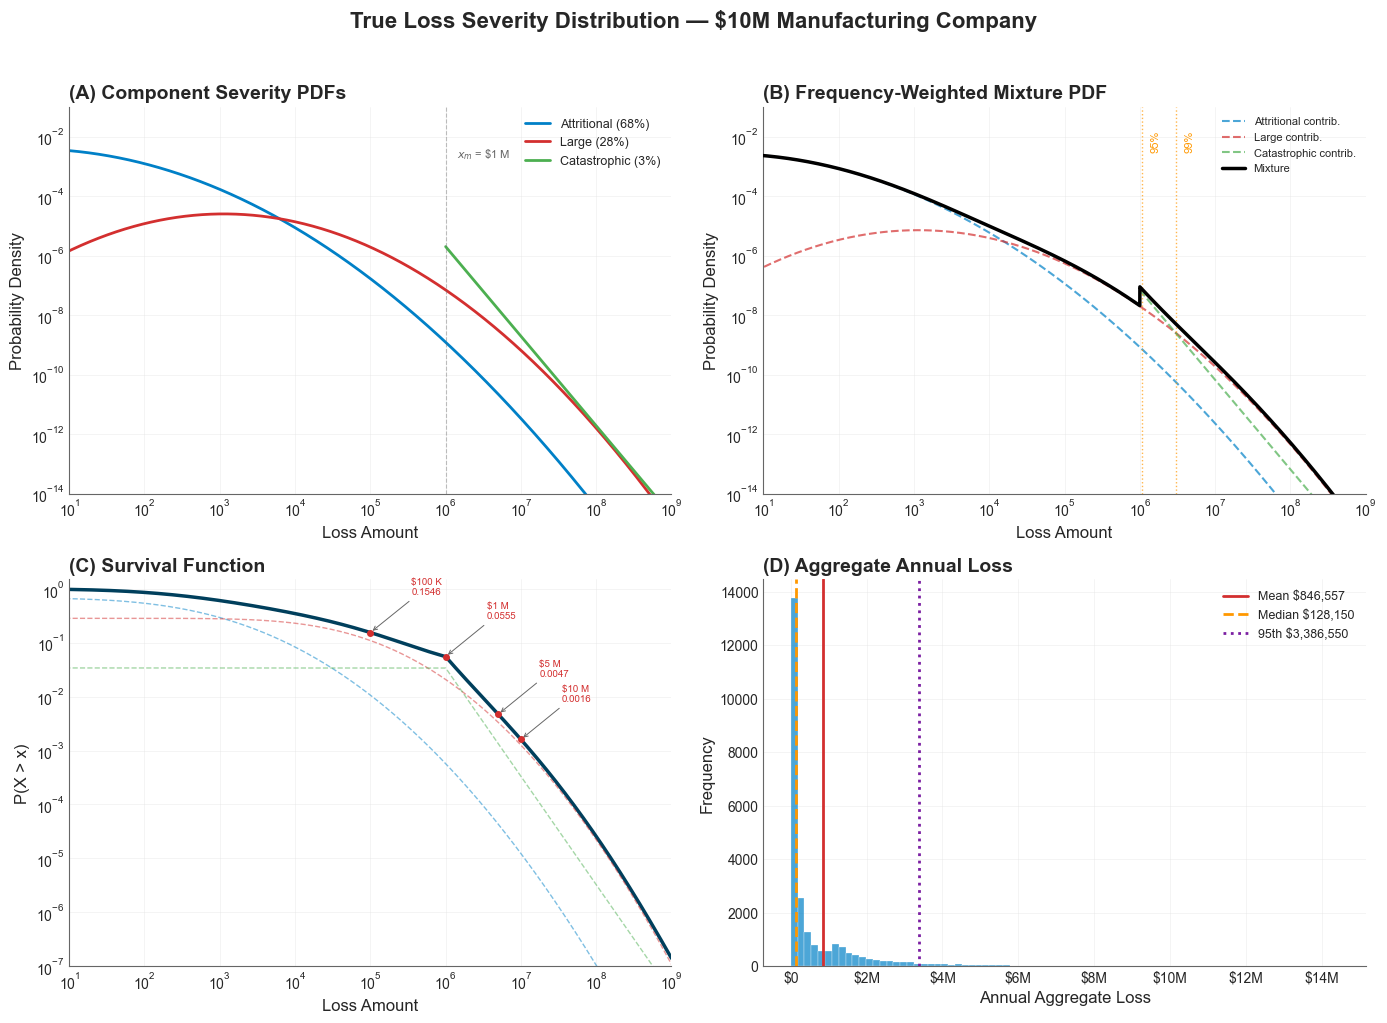


Tail Dominance: which component drives exceedance probability?
   Threshold   Attritional         Large   Catastrophic  Dominant
------------------------------------------------------------------------
  >$     1,000        48.4%        45.9%          5.6%   Attritional
  >$    10,000        24.0%        66.2%          9.8%   Large
  >$   100,000         6.9%        71.0%         22.0%   Large
  >$   500,000         2.0%        51.9%         46.0%   Large
  >$ 1,000,000         1.0%        37.5%         61.5%   Catastrophic
  >$ 5,000,000         0.9%        70.6%         28.4%   Large
  >$10,000,000         0.8%        78.5%         20.7%   Large
  >$50,000,000         0.5%        86.3%         13.2%   Large


In [7]:
# ── Part II Figure: True Severity Distribution ──────────────────
set_wsj_style()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
cat_mask = xg >= CAT_SEV_XM

# ── (A) Component severity PDFs ─────────────────────────────────
ax = axes[0, 0]
ax.loglog(xg, pdf_a, color=C_A, lw=2, label=f"Attritional ({w_a:.0%})")
ax.loglog(xg, pdf_l, color=C_L, lw=2, label=f"Large ({w_l:.0%})")
ax.loglog(xg[cat_mask], pdf_c[cat_mask], color=C_C, lw=2,
          label=f"Catastrophic ({w_c:.0%})")
ax.axvline(CAT_SEV_XM, color=WSJ_COLORS["gray"], ls="--", alpha=0.4, lw=0.8)
ax.text(CAT_SEV_XM * 1.4, 2e-3, r"$x_m$ = \$1 M", fontsize=8,
        color=WSJ_COLORS["gray"])
ax.set_xlim(10, 1e9); ax.set_ylim(1e-14, 1e-1)
ax.set_xlabel("Loss Amount"); ax.set_ylabel("Probability Density")
ax.set_title("(A) Component Severity PDFs", fontweight="bold", loc="left")
ax.legend(fontsize=9, loc="upper right")

# ── (B) Frequency-weighted mixture PDF ──────────────────────────
ax = axes[0, 1]
ax.loglog(xg, w_a * pdf_a, color=C_A, lw=1.5, ls="--", alpha=0.7,
          label="Attritional contrib.")
ax.loglog(xg, w_l * pdf_l, color=C_L, lw=1.5, ls="--", alpha=0.7,
          label="Large contrib.")
ax.loglog(xg[cat_mask], w_c * pdf_c[cat_mask], color=C_C, lw=1.5, ls="--",
          alpha=0.7, label="Catastrophic contrib.")
ax.loglog(xg, pdf_mix, color=WSJ_COLORS["black"], lw=2.5, label="Mixture",
          zorder=5)
# Mark 95th / 99th percentiles
for pi, vi, lbl in [(3, pct_vals[3], "95%"), (4, pct_vals[4], "99%")]:
    ax.axvline(vi, color=WSJ_COLORS["orange"], ls=":", alpha=0.7, lw=1)
    ax.text(vi * 1.3, 3e-3, lbl, fontsize=8, color=WSJ_COLORS["orange"],
            rotation=90, va="bottom")
ax.set_xlim(10, 1e9); ax.set_ylim(1e-14, 1e-1)
ax.set_xlabel("Loss Amount"); ax.set_ylabel("Probability Density")
ax.set_title("(B) Frequency-Weighted Mixture PDF", fontweight="bold", loc="left")
ax.legend(fontsize=8, loc="upper right")

# ── (C) Survival function S(x) = 1 − F(x) ─────────────────────
ax = axes[1, 0]
ax.loglog(xg, sf_mix, color=WSJ_COLORS["dark_blue"], lw=2.5, label="Mixture")
ax.loglog(xg, w_a * (1 - cdf_a), color=C_A, lw=1, ls="--", alpha=0.5)
ax.loglog(xg, w_l * (1 - cdf_l), color=C_L, lw=1, ls="--", alpha=0.5)
sf_c_w = np.where(xg >= CAT_SEV_XM,
                  w_c * (CAT_SEV_XM / xg)**CAT_SEV_ALPHA, w_c)
ax.loglog(xg, sf_c_w, color=C_C, lw=1, ls="--", alpha=0.5)
# Annotate key thresholds
for thr, lbl in [(1e5, "$100 K"), (1e6, "$1 M"), (5e6, "$5 M"), (1e7, "$10 M")]:
    sf_t = float(np.interp(thr, xg, sf_mix))
    ax.plot(thr, sf_t, "o", color=WSJ_COLORS["red"], ms=4, zorder=6)
    ax.annotate(f"{lbl}\n{sf_t:.4f}", xy=(thr, sf_t),
                xytext=(thr * 3.5, sf_t * 5), fontsize=7,
                arrowprops=dict(arrowstyle="->", color=WSJ_COLORS["gray"],
                                lw=0.7),
                color=WSJ_COLORS["red"])
ax.set_xlim(10, 1e9); ax.set_ylim(1e-7, 1.5)
ax.set_xlabel("Loss Amount"); ax.set_ylabel("P(X > x)")
ax.set_title("(C) Survival Function", fontweight="bold", loc="left")

# ── (D) Aggregate annual loss distribution ──────────────────────
ax = axes[1, 1]
clip = np.percentile(agg_annual, 99.5)
ax.hist(agg_annual[agg_annual <= clip], bins=80, color=WSJ_COLORS["blue"],
        alpha=0.7, edgecolor="white", lw=0.3)
ax.axvline(np.mean(agg_annual), color=WSJ_COLORS["red"], lw=2,
           label=f"Mean ${np.mean(agg_annual):,.0f}")
ax.axvline(np.median(agg_annual), color=WSJ_COLORS["orange"], ls="--", lw=2,
           label=f"Median ${np.median(agg_annual):,.0f}")
ax.axvline(np.percentile(agg_annual, 95), color=WSJ_COLORS["purple"], ls=":",
           lw=2, label=f"95th ${np.percentile(agg_annual, 95):,.0f}")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(WSJFormatter.currency_formatter))
ax.set_xlabel("Annual Aggregate Loss"); ax.set_ylabel("Frequency")
ax.set_title("(D) Aggregate Annual Loss", fontweight="bold", loc="left")
ax.legend(fontsize=9)

fig.suptitle("True Loss Severity Distribution — $10M Manufacturing Company",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ── Tail dominance table ────────────────────────────────────────
print("\nTail Dominance: which component drives exceedance probability?")
print(f"{'Threshold':>12}  {'Attritional':>12}  {'Large':>12}  {'Catastrophic':>13}  {'Dominant'}")
print("-" * 72)
for thr in [1e3, 1e4, 1e5, 5e5, 1e6, 5e6, 1e7, 5e7]:
    sa = w_a * (1 - sp_lognorm.cdf(thr, s=attr_sig, scale=np.exp(attr_mu)))
    sl = w_l * (1 - sp_lognorm.cdf(thr, s=lg_sig,   scale=np.exp(lg_mu)))
    sc = w_c * ((CAT_SEV_XM / thr)**CAT_SEV_ALPHA if thr >= CAT_SEV_XM else 1.0)
    st = sa + sl + sc
    dom = ("Attritional" if sa >= max(sl, sc)
           else ("Large" if sl >= sc else "Catastrophic"))
    print(f"  >${thr:>10,.0f}  {sa/st:>11.1%}  {sl/st:>11.1%}  {sc/st:>12.1%}   {dom}")

## Part III: Estimating Losses from Historical Data

In [8]:
# ═══════════════════════════════════════════════════════════════════
# PART III — 5-YEAR SAMPLE, MLE, AND SHADOW MOMENTS
# ═══════════════════════════════════════════════════════════════════
# Draw 5 years of losses from the true distribution for a single
# $10M manufacturing company.  Split at $100K to separate attritional
# from large.  Fit lognormal MLE to each group.  The catastrophic
# component (freq = 0.15/yr) has ~47% chance of zero events in 5 yrs.

set_wsj_style()
SPLIT_THRESHOLD = 100_000  # actuarial development threshold

# ── Generate 5-year sample ──────────────────────────────────────
_gen5 = ManufacturingLossGenerator(**LOSS_PARAMS, seed=SEED + 200)
events_5yr, yearly_events = [], {}
for yr in range(1, 6):
    evts, _ = _gen5.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    yearly_events[yr] = evts
    events_5yr.extend(evts)

amounts  = np.array([e.amount    for e in events_5yr])
types    = np.array([e.loss_type for e in events_5yr])
years_ev = np.array([yr for yr in range(1, 6) for _ in yearly_events[yr]])

n_attr_obs  = int((types == "attritional").sum())
n_large_obs = int((types == "large").sum())
n_cat_obs   = int((types == "catastrophic").sum())

print("5-Year Loss Experience — Our $10M Company")
print("=" * 60)
print(f"Total events: {len(amounts)}  (expected ≈ {freq_total * 5:.0f})")
print(f"  Attritional:  {n_attr_obs:>3}  (exp. {ATTR_BASE_FREQ*5:.0f})")
print(f"  Large:        {n_large_obs:>3}  (exp. {LG_BASE_FREQ*5:.1f})")
print(f"  Catastrophic: {n_cat_obs:>3}  (exp. {CAT_BASE_FREQ*5:.2f},"
      f" P(0 in 5yr) = {np.exp(-CAT_BASE_FREQ*5):.0%})")

print(f"\n{'Year':>4} {'Events':>7} {'Total':>14} {'Max':>14}")
print("-" * 44)
for yr in range(1, 6):
    ya = np.array([e.amount for e in yearly_events[yr]])
    print(f"{yr:>4} {len(ya):>7} ${ya.sum():>13,.0f}"
          f" ${ya.max() if len(ya) else 0:>13,.0f}")

# ── Split at threshold ──────────────────────────────────────────
below      = amounts[amounts < SPLIT_THRESHOLD]
above      = amounts[(amounts >= SPLIT_THRESHOLD) & (amounts < 5e6)]
very_large = amounts[amounts >= 5e6]

print(f"\nThreshold split at ${SPLIT_THRESHOLD:,.0f}:")
print(f"  < ${SPLIT_THRESHOLD/1e3:.0f}K  (attritional proxy): {len(below):>3} events")
print(f"  ${SPLIT_THRESHOLD/1e3:.0f}K–$5M (large proxy):      {len(above):>3} events")
print(f"  ≥ $5M (catastrophic proxy):    {len(very_large):>3} events")

# ── Lognormal MLE for each group ────────────────────────────────
def lognormal_mle(data):
    """Return (mu, sigma, implied_mean, implied_cv) from log-data MLE."""
    ln_d = np.log(data)
    mu   = np.mean(ln_d)
    sig  = np.std(ln_d, ddof=0)          # MLE uses N, not N-1
    return mu, sig, np.exp(mu + sig**2 / 2), np.sqrt(np.exp(sig**2) - 1)

mle_a = lognormal_mle(below)  if len(below)  >= 3 else (np.nan,)*4
mle_l = lognormal_mle(above)  if len(above)  >= 3 else (np.nan,)*4

print(f"\n{'─'*60}")
print("Lognormal MLE Parameter Estimates")
print(f"{'─'*60}")
hdr = f"{'':16} {'μ':>10} {'σ':>10} {'Mean':>14} {'CV':>8}"
print(hdr); print("-" * len(hdr))
print(f"{'Attr MLE':<16} {mle_a[0]:>10.3f} {mle_a[1]:>10.3f}"
      f" ${mle_a[2]:>13,.0f} {mle_a[3]:>7.1f}")
print(f"{'Attr TRUE':<16} {attr_mu:>10.3f} {attr_sig:>10.3f}"
      f" ${ATTR_SEV_MEAN:>13,.0f} {ATTR_SEV_CV:>7.1f}")
print(f"{'Large MLE':<16} {mle_l[0]:>10.3f} {mle_l[1]:>10.3f}"
      f" ${mle_l[2]:>13,.0f} {mle_l[3]:>7.1f}")
print(f"{'Large TRUE':<16} {lg_mu:>10.3f} {lg_sig:>10.3f}"
      f" ${LG_SEV_MEAN:>13,.0f} {LG_SEV_CV:>7.1f}")

if len(very_large) > 0:
    print(f"\n  Note: {len(very_large)} loss(es) >= $5M observed — possible"
          " catastrophic event(s)")
else:
    print(f"\n  Note: No losses >= $5M — catastrophic tail is entirely hidden")

# ── Shadow Moments ──────────────────────────────────────────────
sample_sev_mean = float(np.mean(amounts))
sample_ann_mean = float(np.sum(amounts)) / 5
true_ann_mean   = freq_total * mix_mean

# What fraction of the true severity mean comes from catastrophic?
cat_share = w_c * cat_mean / mix_mean

print(f"\n{'='*60}")
print("SHADOW MOMENTS  (Taleb)")
print(f"{'='*60}")
print("The sample moments systematically underestimate the truth")
print("because catastrophic events are too rare to appear reliably.\n")
print(f"{'Metric':<28} {'Sample':>14} {'True':>14} {'Hidden':>8}")
print("-" * 68)
print(f"{'Per-event severity mean':<28} ${sample_sev_mean:>13,.0f}"
      f" ${mix_mean:>13,.0f}"
      f" {(mix_mean - sample_sev_mean)/mix_mean:>7.0%}")
print(f"{'Annual aggregate mean':<28} ${sample_ann_mean:>13,.0f}"
      f" ${true_ann_mean:>13,.0f}"
      f" {(true_ann_mean - sample_ann_mean)/true_ann_mean:>7.0%}")
print(f"{'Max observed event':<28} ${np.max(amounts):>13,.0f}")
print(f"\nThe catastrophic component is only {w_c:.1%} of events by count")
print(f"but contributes {cat_share:.0%} of the true per-event severity mean.")
print(f"With {n_cat_obs} cat event(s) in 5 years, that tail is"
      f" {'invisible' if n_cat_obs == 0 else 'barely glimpsed'}.")

5-Year Loss Experience — Our $10M Company
Total events: 22  (expected ≈ 22)
  Attritional:   15  (exp. 15)
  Large:          6  (exp. 6.2)
  Catastrophic:   1  (exp. 0.75, P(0 in 5yr) = 47%)

Year  Events          Total            Max
--------------------------------------------
   1       3 $    2,403,953 $    2,401,047
   2       7 $    2,842,020 $    2,831,242
   3       5 $    1,557,518 $    1,241,749
   4       3 $    2,722,691 $    2,601,405
   5       4 $      105,151 $       96,409

Threshold split at $100,000:
  < $100K  (attritional proxy):  16 events
  $100K–$5M (large proxy):        6 events
  ≥ $5M (catastrophic proxy):      0 events

────────────────────────────────────────────────────────────
Lognormal MLE Parameter Estimates
────────────────────────────────────────────────────────────
                          μ          σ           Mean       CV
--------------------------------------------------------------
Attr MLE              7.034      2.280 $       15,259    13.4


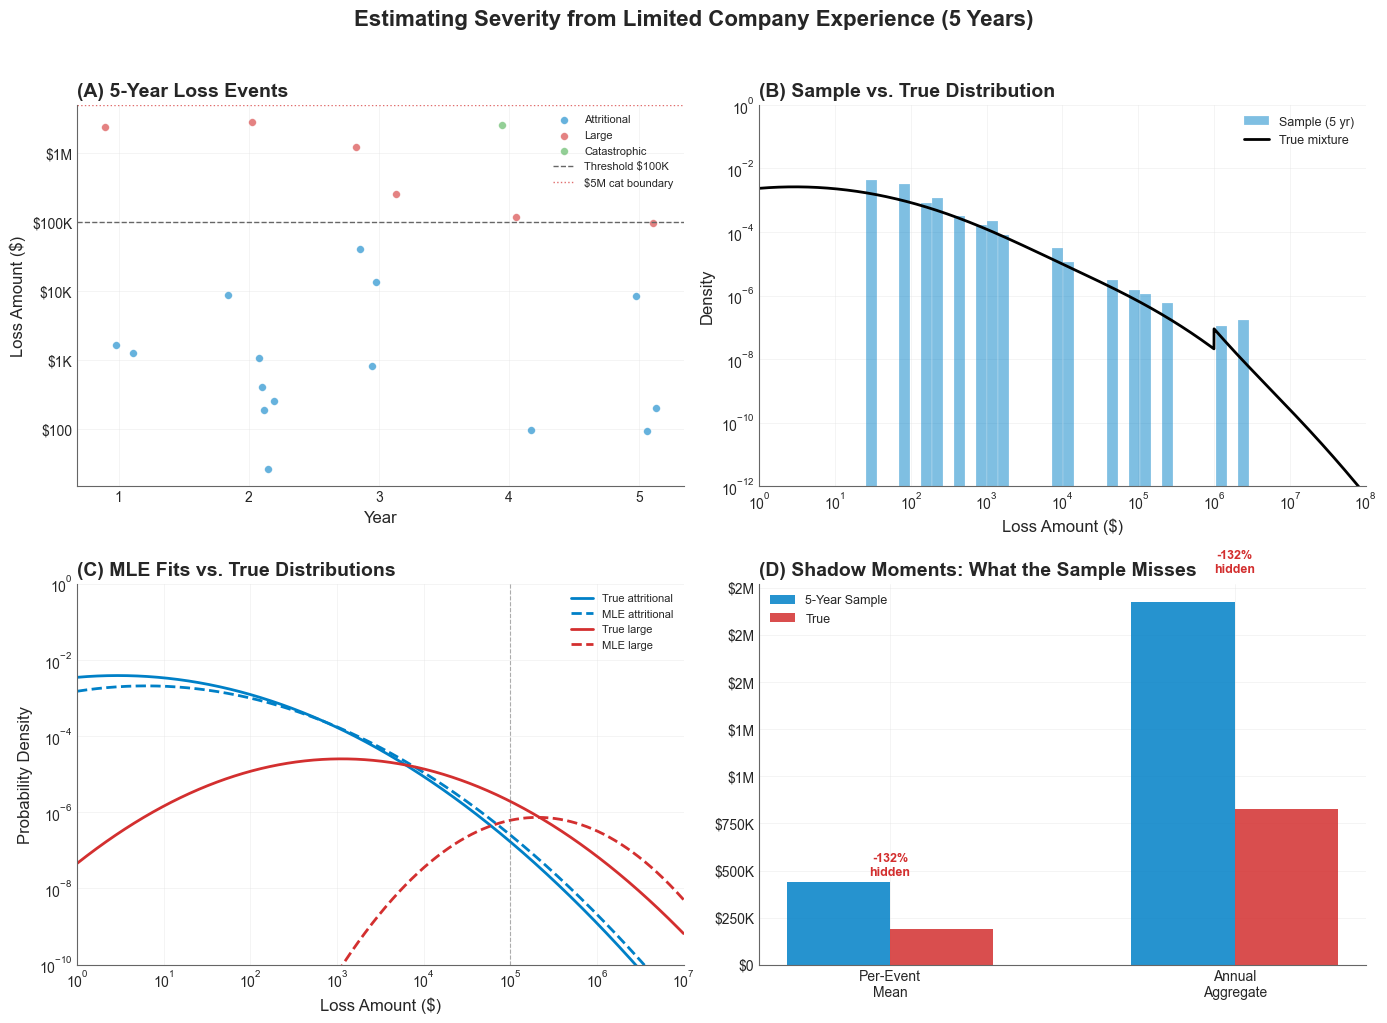

In [9]:
# ── Part III Figure: Sample, MLE Fits, and Shadow Moments ───────
set_wsj_style()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── (A) 5-year events scatter (log-scale) ───────────────────────
ax = axes[0, 0]
_rng_jit = np.random.default_rng(42)
type_colors = {"attritional": C_A, "large": C_L, "catastrophic": C_C}
for t_name in ["attritional", "large", "catastrophic"]:
    mask_t = types == t_name
    if mask_t.any():
        jit = _rng_jit.uniform(-0.2, 0.2, mask_t.sum())
        ax.scatter(years_ev[mask_t] + jit, amounts[mask_t],
                   c=type_colors[t_name], alpha=0.6, s=30,
                   label=t_name.capitalize(), edgecolors="white", lw=0.3)
ax.set_yscale("log")
ax.axhline(SPLIT_THRESHOLD, color=WSJ_COLORS["gray"], ls="--", lw=1,
           label=f"Threshold ${SPLIT_THRESHOLD/1e3:.0f}K")
ax.axhline(5e6, color=WSJ_COLORS["red"], ls=":", lw=1, alpha=0.7,
           label="$5M cat boundary")
ax.set_xlabel("Year"); ax.set_ylabel("Loss Amount ($)")
ax.set_title("(A) 5-Year Loss Events", fontweight="bold", loc="left")
ax.set_xticks([1, 2, 3, 4, 5])
ax.yaxis.set_major_formatter(mticker.FuncFormatter(WSJFormatter.currency_formatter))
ax.legend(fontsize=8, loc="upper right")

# ── (B) Sample histogram vs true PDF ────────────────────────────
ax = axes[0, 1]
lo = max(amounts.min() * 0.5, 1)
bins_log = np.logspace(np.log10(lo), np.log10(amounts.max() * 2), 40)
ax.hist(amounts, bins=bins_log, density=True, color=WSJ_COLORS["blue"],
        alpha=0.5, edgecolor="white", lw=0.3, label="Sample (5 yr)")
ax.loglog(xg, pdf_mix, color=WSJ_COLORS["black"], lw=2, label="True mixture")
ax.set_xlim(1, 1e8); ax.set_ylim(1e-12, 1)
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Density")
ax.set_title("(B) Sample vs. True Distribution", fontweight="bold", loc="left")
ax.legend(fontsize=9)

# ── (C) MLE fits vs true (attritional + large) ─────────────────
ax = axes[1, 0]
xf = np.logspace(0, 7, 2000)
ax.loglog(xf, sp_lognorm.pdf(xf, s=attr_sig, scale=np.exp(attr_mu)),
          color=C_A, lw=2, label="True attritional")
if not np.isnan(mle_a[0]):
    ax.loglog(xf, sp_lognorm.pdf(xf, s=mle_a[1], scale=np.exp(mle_a[0])),
              color=C_A, lw=2, ls="--", label="MLE attritional")
ax.loglog(xf, sp_lognorm.pdf(xf, s=lg_sig, scale=np.exp(lg_mu)),
          color=C_L, lw=2, label="True large")
if not np.isnan(mle_l[0]):
    ax.loglog(xf, sp_lognorm.pdf(xf, s=mle_l[1], scale=np.exp(mle_l[0])),
              color=C_L, lw=2, ls="--", label="MLE large")
ax.axvline(SPLIT_THRESHOLD, color=WSJ_COLORS["gray"], ls="--", lw=0.8,
           alpha=0.5)
ax.set_xlim(1, 1e7); ax.set_ylim(1e-10, 1)
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Probability Density")
ax.set_title("(C) MLE Fits vs. True Distributions", fontweight="bold",
             loc="left")
ax.legend(fontsize=8, loc="upper right")

# ── (D) Shadow moments bar comparison ───────────────────────────
ax = axes[1, 1]
labels  = ["Per-Event\nMean", "Annual\nAggregate"]
s_vals  = [sample_sev_mean, sample_ann_mean]
t_vals  = [mix_mean, true_ann_mean]
x_pos   = np.arange(len(labels))
bw = 0.30
ax.bar(x_pos - bw/2, s_vals, bw, color=WSJ_COLORS["blue"], label="5-Year Sample",
       alpha=0.85)
ax.bar(x_pos + bw/2, t_vals, bw, color=WSJ_COLORS["red"], label="True",
       alpha=0.85)
# Annotate the hidden fraction
for i, (sv, tv) in enumerate(zip(s_vals, t_vals)):
    pct = (tv - sv) / tv * 100
    ax.text(i, max(sv, tv) * 1.08,
            f"{pct:.0f}%\nhidden", ha="center", fontsize=9,
            color=WSJ_COLORS["red"], fontweight="bold")
ax.set_xticks(x_pos); ax.set_xticklabels(labels)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(WSJFormatter.currency_formatter))
ax.set_title("(D) Shadow Moments: What the Sample Misses",
             fontweight="bold", loc="left")
ax.legend(fontsize=9)

fig.suptitle("Estimating Severity from Limited Company Experience (5 Years)",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Part IV: Estimating the Tail from Industry Catastrophes

In [10]:
# ═══════════════════════════════════════════════════════════════════
# PART IV — INDUSTRY CATASTROPHIC TAIL ESTIMATION
# ═══════════════════════════════════════════════════════════════════
# Simulate ~10,000 companies/year × 15 years, each with the same
# catastrophic Pareto(α=2.01, xm=$1M, freq=0.15) distribution.
# We observe ONLY losses ≥ $5M.  We do NOT know the exposure base.
#
# Key insight: for Pareto data truncated at threshold t,
#   X | X ≥ t  ~  Pareto(α, t)    (same shape, shifted scale)
# so α can be estimated WITHOUT knowing exposures.
#
# Bayesian conjugate:
#   Prior:      α ~ Gamma(a₀, b₀)
#   Likelihood: L(α | x) ∝ αⁿ exp(−α S)   where S = Σ ln(xᵢ/t)
#   Posterior:  α | data ~ Gamma(a₀ + n, b₀ + S)

set_wsj_style()
IND_THRESHOLD  = 5_000_000
N_YEARS_IND    = 15
LAMBDA_COMPANY = 10_000

# ── Simulate industry database ──────────────────────────────────
_rng = np.random.default_rng(SEED + 300)
industry_losses = []
_tot_comp_yr, _tot_cat = 0, 0

for _ in range(N_YEARS_IND):
    n_co = _rng.poisson(LAMBDA_COMPANY)
    _tot_comp_yr += n_co
    n_events = _rng.poisson(CAT_BASE_FREQ, size=n_co)  # events per company
    tot_ev = int(n_events.sum())
    _tot_cat += tot_ev
    if tot_ev > 0:
        u = _rng.random(tot_ev)
        sevs = CAT_SEV_XM / u ** (1 / CAT_SEV_ALPHA)
        industry_losses.extend(sevs[sevs >= IND_THRESHOLD])

industry_losses = np.array(industry_losses)
n_ind = len(industry_losses)

print("Industry Catastrophic Loss Database")
print("=" * 60)
print(f"Simulation: {N_YEARS_IND} years, ~{LAMBDA_COMPANY:,} companies/year")
print(f"Observable losses ≥ ${IND_THRESHOLD:,.0f}: {n_ind:,}")
print(f"(Hidden: {_tot_comp_yr:,} company-years, {_tot_cat:,} total cat events)")
print(f"\nThe analyst sees ONLY {n_ind:,} loss amounts.")
print(f"  Mean:   ${np.mean(industry_losses):>14,.0f}")
print(f"  Median: ${np.median(industry_losses):>14,.0f}")
print(f"  Max:    ${np.max(industry_losses):>14,.0f}")

# ── Hill Estimator (MLE for truncated Pareto) ───────────────────
# α̂ = n / Σ ln(xᵢ / t),   SE = α̂ / √n
S_hill     = np.sum(np.log(industry_losses / IND_THRESHOLD))
alpha_hill = n_ind / S_hill
se_hill    = alpha_hill / np.sqrt(n_ind)

print(f"\nHill Estimator (MLE):")
print(f"  α̂ = {alpha_hill:.4f}  ±  {se_hill:.4f}   (true α = {CAT_SEV_ALPHA})")
print(f"  95% CI: [{alpha_hill - 1.96*se_hill:.3f},"
      f" {alpha_hill + 1.96*se_hill:.3f}]")

# ── Hill Plot (α̂ vs. threshold) ─────────────────────────────────
_thr_grid = np.logspace(np.log10(IND_THRESHOLD),
                        np.log10(np.percentile(industry_losses, 95)), 40)
hill_alpha = np.full_like(_thr_grid, np.nan)
hill_n     = np.zeros(len(_thr_grid), dtype=int)
for j, t in enumerate(_thr_grid):
    above = industry_losses[industry_losses >= t]
    if len(above) >= 10:
        hill_alpha[j] = len(above) / np.sum(np.log(above / t))
        hill_n[j]     = len(above)

# ── Bayesian Conjugate ──────────────────────────────────────────
a0, b0 = 2.0, 1.0                           # weakly informative prior
a_post = a0 + n_ind
b_post = b0 + S_hill
post_mean = a_post / b_post
post_mode = (a_post - 1) / b_post
post_std  = np.sqrt(a_post) / b_post
ci_lo = sp_gamma.ppf(0.025, a=a_post, scale=1/b_post)
ci_hi = sp_gamma.ppf(0.975, a=a_post, scale=1/b_post)

print(f"\nBayesian Conjugate Analysis:")
print(f"  Prior:     Gamma(a₀={a0:.0f}, b₀={b0:.0f})  →  mean = {a0/b0:.1f}")
print(f"  Posterior: Gamma({a_post:.0f}, {b_post:.1f})")
print(f"  Mean  = {post_mean:.4f}")
print(f"  Mode  = {post_mode:.4f}")
print(f"  Std   = {post_std:.4f}")
print(f"  95% credible interval: [{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"  True α = {CAT_SEV_ALPHA}")

# ── Implied tail risk under posterior α ─────────────────────────
def pareto_exceed(loss_level, alpha_val, xm=CAT_SEV_XM):
    """P(X > loss_level | cat event) for Pareto(alpha, xm)."""
    return (xm / loss_level) ** alpha_val if loss_level >= xm else 1.0

cat_mean_post = post_mean * CAT_SEV_XM / (post_mean - 1)
print(f"\nImplied tail risk (posterior mean α = {post_mean:.3f}):")
print(f"  E[cat severity]         = ${cat_mean_post:>12,.0f}"
      f"   (true: ${cat_mean:>12,.0f})")
for lvl, lbl in [(5e6, "$5M"), (1e7, "$10M"), (5e7, "$50M")]:
    pp = pareto_exceed(lvl, post_mean)
    pt = pareto_exceed(lvl, CAT_SEV_ALPHA)
    print(f"  P(cat > {lbl:>4s} | event) = {pp:.5f}"
          f"   (true: {pt:.5f})")

print(f"\n{'='*60}")
print("KEY INSIGHT")
print("The truncated Pareto likelihood depends only on α and the")
print("loss amounts above the threshold — NOT on the exposure base.")
print("We estimate the tail shape from industry data without knowing")
print("how many companies contributed.  Frequency estimation requires")
print("separate data (e.g., our company's own event counts).")
print(f"{'='*60}")

Industry Catastrophic Loss Database
Simulation: 15 years, ~10,000 companies/year
Observable losses ≥ $5,000,000: 845
(Hidden: 149,446 company-years, 22,479 total cat events)

The analyst sees ONLY 845 loss amounts.
  Mean:   $     9,988,278
  Median: $     7,154,886
  Max:    $   127,221,246

Hill Estimator (MLE):
  α̂ = 1.9343  ±  0.0665   (true α = 2.01)
  95% CI: [1.804, 2.065]

Bayesian Conjugate Analysis:
  Prior:     Gamma(a₀=2, b₀=1)  →  mean = 2.0
  Posterior: Gamma(847, 437.9)
  Mean  = 1.9344
  Mode  = 1.9321
  Std   = 0.0665
  95% credible interval: [1.8063, 2.0668]
  True α = 2.01

Implied tail risk (posterior mean α = 1.934):
  E[cat severity]         = $   2,070,193   (true: $   1,990,099)
  P(cat >  $5M | event) = 0.04445   (true: 0.03936)
  P(cat > $10M | event) = 0.01163   (true: 0.00977)
  P(cat > $50M | event) = 0.00052   (true: 0.00038)

KEY INSIGHT
The truncated Pareto likelihood depends only on α and the
loss amounts above the threshold — NOT on the exposure base.

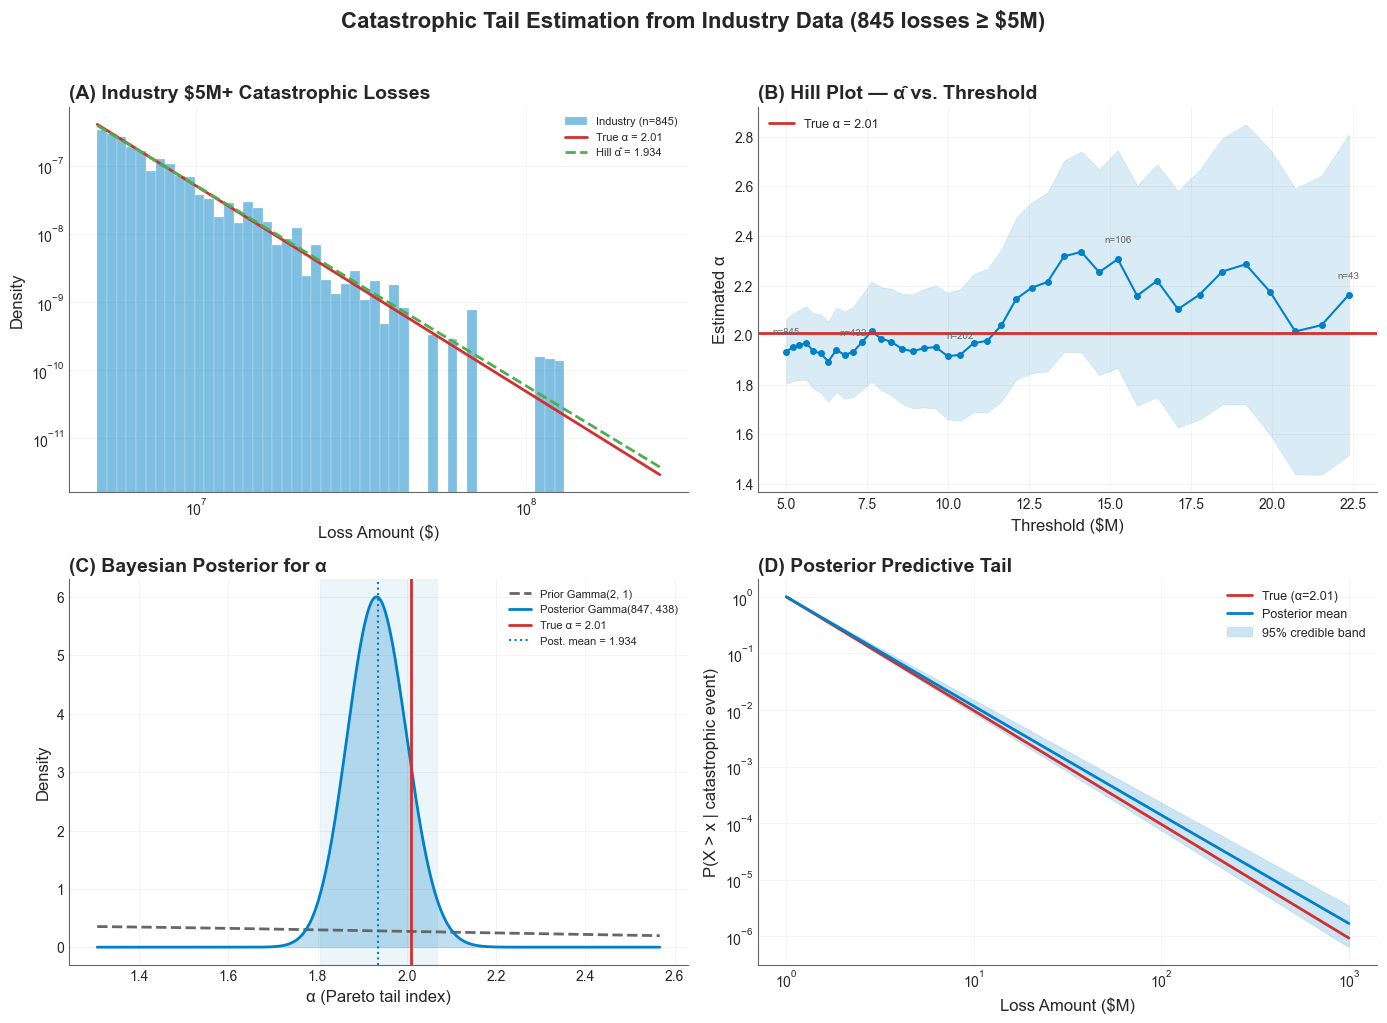


Prior Sensitivity: how much does the prior matter?
               Prior    Post. Mean            Post. 95% CI
------------------------------------------------------------
   Gamma(2,1) — weak        1.9344  [1.8063, 2.0668]
Gamma(1,0.5) — vague        1.9343  [1.8062, 2.0668]
Gamma(4,2) — moderate        1.9346  [1.8066, 2.0668]
Gamma(ε,ε) — Jeffreys        1.9343  [1.8060, 2.0668]

With n = 845 observations, the prior barely matters —
the data dominate the posterior.


In [11]:
# ── Part IV Figure: Industry Tail Estimation ────────────────────
set_wsj_style()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── (A) Industry loss histogram + Pareto fits ──────────────────
ax = axes[0, 0]
bins_ind = np.logspace(np.log10(IND_THRESHOLD),
                       np.log10(industry_losses.max() * 1.1), 50)
ax.hist(industry_losses, bins=bins_ind, density=True, color=WSJ_COLORS["blue"],
        alpha=0.5, edgecolor="white", lw=0.3, label=f"Industry (n={n_ind:,})")
xp = np.logspace(np.log10(IND_THRESHOLD),
                 np.log10(industry_losses.max() * 2), 500)
# Truncated Pareto PDF: f(x|α,t) = α tᵅ x^(−α−1) for x ≥ t
pdf_true_trunc = (CAT_SEV_ALPHA * IND_THRESHOLD**CAT_SEV_ALPHA
                  * xp**(-CAT_SEV_ALPHA - 1))
pdf_hill_trunc = (alpha_hill * IND_THRESHOLD**alpha_hill
                  * xp**(-alpha_hill - 1))
ax.loglog(xp, pdf_true_trunc, color=WSJ_COLORS["red"], lw=2,
          label=f"True α = {CAT_SEV_ALPHA}")
ax.loglog(xp, pdf_hill_trunc, color=WSJ_COLORS["green"], lw=2, ls="--",
          label=f"Hill α̂ = {alpha_hill:.3f}")
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Density")
ax.set_title("(A) Industry $5M+ Catastrophic Losses",
             fontweight="bold", loc="left")
ax.legend(fontsize=8)

# ── (B) Hill Plot: α̂ stability across thresholds ───────────────
ax = axes[0, 1]
valid = ~np.isnan(hill_alpha)
ax.plot(_thr_grid[valid] / 1e6, hill_alpha[valid], "o-",
        color=WSJ_COLORS["blue"], ms=4, lw=1.5)
# 95% pointwise CI
hill_se = hill_alpha[valid] / np.sqrt(hill_n[valid])
ax.fill_between(_thr_grid[valid] / 1e6,
                hill_alpha[valid] - 1.96 * hill_se,
                hill_alpha[valid] + 1.96 * hill_se,
                alpha=0.15, color=WSJ_COLORS["blue"])
ax.axhline(CAT_SEV_ALPHA, color=WSJ_COLORS["red"], lw=2,
           label=f"True α = {CAT_SEV_ALPHA}")
# Annotate sample sizes at a few points
ann_idx = np.linspace(0, valid.sum() - 1, 5, dtype=int)
for j in ann_idx:
    ax.annotate(f"n={hill_n[valid][j]}",
                xy=(_thr_grid[valid][j] / 1e6, hill_alpha[valid][j]),
                textcoords="offset points", xytext=(0, 12), fontsize=7,
                color=WSJ_COLORS["gray"], ha="center")
ax.set_xlabel("Threshold ($M)"); ax.set_ylabel("Estimated α")
ax.set_title("(B) Hill Plot — α̂ vs. Threshold", fontweight="bold", loc="left")
ax.legend(fontsize=9)

# ── (C) Prior and Posterior for α ───────────────────────────────
ax = axes[1, 0]
alpha_grid = np.linspace(max(0.5, ci_lo - 0.5), ci_hi + 0.5, 500)
prior_pdf = sp_gamma.pdf(alpha_grid, a=a0, scale=1/b0)
post_pdf  = sp_gamma.pdf(alpha_grid, a=a_post, scale=1/b_post)
ax.plot(alpha_grid, prior_pdf, color=WSJ_COLORS["gray"], lw=2, ls="--",
        label=f"Prior Gamma({a0:.0f}, {b0:.0f})")
ax.fill_between(alpha_grid, 0, post_pdf, alpha=0.25, color=WSJ_COLORS["blue"])
ax.plot(alpha_grid, post_pdf, color=WSJ_COLORS["blue"], lw=2,
        label=f"Posterior Gamma({a_post:.0f}, {b_post:.0f})")
ax.axvline(CAT_SEV_ALPHA, color=WSJ_COLORS["red"], lw=2,
           label=f"True α = {CAT_SEV_ALPHA}")
ax.axvline(post_mean, color=WSJ_COLORS["blue"], ls=":", lw=1.5,
           label=f"Post. mean = {post_mean:.3f}")
ax.axvspan(ci_lo, ci_hi, alpha=0.08, color=WSJ_COLORS["blue"])
ax.set_xlabel("α (Pareto tail index)"); ax.set_ylabel("Density")
ax.set_title("(C) Bayesian Posterior for α", fontweight="bold", loc="left")
ax.legend(fontsize=8, loc="upper right")

# ── (D) Posterior predictive tail vs. true ──────────────────────
ax = axes[1, 1]
x_tail = np.logspace(np.log10(CAT_SEV_XM), 9, 500)
# Sample α from posterior → survival curves
_alpha_samples = sp_gamma.rvs(a=a_post, scale=1/b_post, size=1000,
                              random_state=42)
sf_samples = np.array([(CAT_SEV_XM / x_tail)**a_s for a_s in _alpha_samples])
sf_post_mean = sf_samples.mean(axis=0)
sf_post_lo   = np.percentile(sf_samples,  2.5, axis=0)
sf_post_hi   = np.percentile(sf_samples, 97.5, axis=0)
sf_true_tail = (CAT_SEV_XM / x_tail) ** CAT_SEV_ALPHA

ax.loglog(x_tail / 1e6, sf_true_tail, color=WSJ_COLORS["red"], lw=2,
          label=f"True (α={CAT_SEV_ALPHA})")
ax.loglog(x_tail / 1e6, sf_post_mean, color=WSJ_COLORS["blue"], lw=2,
          label="Posterior mean")
ax.fill_between(x_tail / 1e6, sf_post_lo, sf_post_hi, alpha=0.2,
                color=WSJ_COLORS["blue"], label="95% credible band")
ax.set_xlabel("Loss Amount ($M)")
ax.set_ylabel("P(X > x | catastrophic event)")
ax.set_title("(D) Posterior Predictive Tail", fontweight="bold", loc="left")
ax.legend(fontsize=9)

fig.suptitle("Catastrophic Tail Estimation from Industry Data"
             f" ({n_ind:,} losses ≥ $5M)",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ── Prior sensitivity check ─────────────────────────────────────
print("\nPrior Sensitivity: how much does the prior matter?")
print(f"{'Prior':>20}  {'Post. Mean':>12}  {'Post. 95% CI':>22}")
print("-" * 60)
for a_pr, b_pr, lbl in [(2, 1, "Gamma(2,1) — weak"),
                         (1, 0.5, "Gamma(1,0.5) — vague"),
                         (4, 2, "Gamma(4,2) — moderate"),
                         (0.001, 0.001, "Gamma(ε,ε) — Jeffreys")]:
    ap = a_pr + n_ind
    bp = b_pr + S_hill
    pm = ap / bp
    lo = sp_gamma.ppf(0.025, a=ap, scale=1/bp)
    hi = sp_gamma.ppf(0.975, a=ap, scale=1/bp)
    print(f"{lbl:>20}  {pm:>12.4f}  [{lo:.4f}, {hi:.4f}]")
print(f"\nWith n = {n_ind:,} observations, the prior barely matters —")
print(f"the data dominate the posterior.")

## Part V: Comparing Estimated vs "True" Distribution

ValueError: x and y must have same first dimension, but have shapes (5000,) and (10000,)

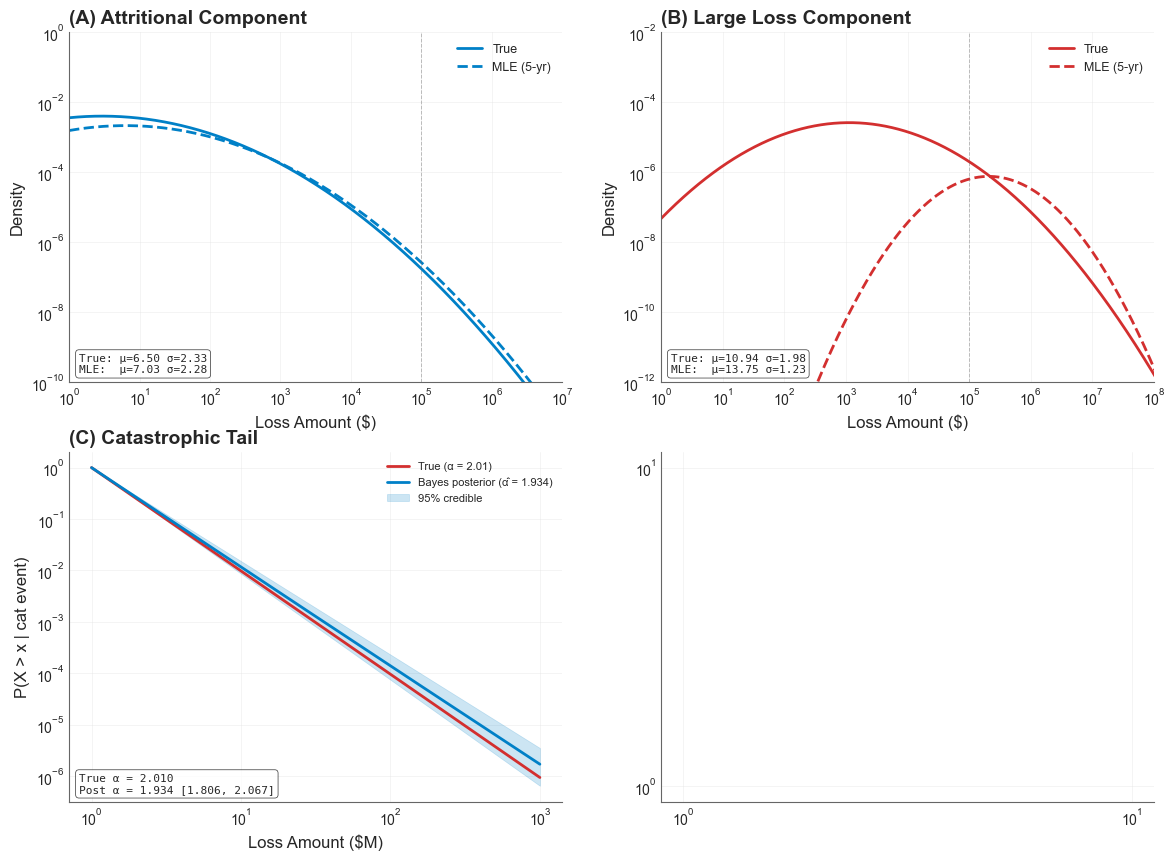

In [12]:
# ═══════════════════════════════════════════════════════════════════
# PART V — COMPARING TRUE vs. ESTIMATED DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════
# Bring together:
#   Attritional & Large  → Lognormal MLE from 5-year company data
#   Catastrophic         → Bayesian posterior from industry data
#   Frequency            → Observed counts from company + industry prior
# Compare to the "true" mixture that generated the data.

set_wsj_style()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
xf = np.logspace(0, 9, 5000)

# ── (A) Attritional: True vs MLE ───────────────────────────────
ax = axes[0, 0]
ax.loglog(xf, sp_lognorm.pdf(xf, s=attr_sig, scale=np.exp(attr_mu)),
          color=C_A, lw=2, label="True")
if not np.isnan(mle_a[0]):
    ax.loglog(xf, sp_lognorm.pdf(xf, s=mle_a[1], scale=np.exp(mle_a[0])),
              color=C_A, lw=2, ls="--", label="MLE (5-yr)")
ax.axvline(SPLIT_THRESHOLD, color=WSJ_COLORS["gray"], ls="--", lw=0.7,
           alpha=0.4)
ax.set_xlim(1, 1e7); ax.set_ylim(1e-10, 1)
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Density")
ax.set_title("(A) Attritional Component", fontweight="bold", loc="left")
ax.legend(fontsize=9)
# Inset text with key parameter comparison
if not np.isnan(mle_a[0]):
    ax.text(0.02, 0.02,
            f"True: μ={attr_mu:.2f} σ={attr_sig:.2f}\n"
            f"MLE:  μ={mle_a[0]:.2f} σ={mle_a[1]:.2f}",
            transform=ax.transAxes, fontsize=8, verticalalignment="bottom",
            fontfamily="monospace",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# ── (B) Large: True vs MLE ─────────────────────────────────────
ax = axes[0, 1]
ax.loglog(xf, sp_lognorm.pdf(xf, s=lg_sig, scale=np.exp(lg_mu)),
          color=C_L, lw=2, label="True")
if not np.isnan(mle_l[0]):
    ax.loglog(xf, sp_lognorm.pdf(xf, s=mle_l[1], scale=np.exp(mle_l[0])),
              color=C_L, lw=2, ls="--", label="MLE (5-yr)")
ax.axvline(SPLIT_THRESHOLD, color=WSJ_COLORS["gray"], ls="--", lw=0.7,
           alpha=0.4)
ax.set_xlim(1, 1e8); ax.set_ylim(1e-12, 1e-2)
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Density")
ax.set_title("(B) Large Loss Component", fontweight="bold", loc="left")
ax.legend(fontsize=9)
if not np.isnan(mle_l[0]):
    ax.text(0.02, 0.02,
            f"True: μ={lg_mu:.2f} σ={lg_sig:.2f}\n"
            f"MLE:  μ={mle_l[0]:.2f} σ={mle_l[1]:.2f}",
            transform=ax.transAxes, fontsize=8, verticalalignment="bottom",
            fontfamily="monospace",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# ── (C) Catastrophic: True vs Bayesian posterior ────────────────
ax = axes[1, 0]
xt = np.logspace(np.log10(CAT_SEV_XM), 9, 500)
sf_true_c = (CAT_SEV_XM / xt) ** CAT_SEV_ALPHA
ax.loglog(xt / 1e6, sf_true_c, color=WSJ_COLORS["red"], lw=2,
          label=f"True (α = {CAT_SEV_ALPHA})")
ax.loglog(xt / 1e6, sf_post_mean, color=WSJ_COLORS["blue"], lw=2,
          label=f"Bayes posterior (α̂ = {post_mean:.3f})")
ax.fill_between(xt / 1e6, sf_post_lo, sf_post_hi, alpha=0.2,
                color=WSJ_COLORS["blue"], label="95% credible")
ax.set_xlabel("Loss Amount ($M)")
ax.set_ylabel("P(X > x | cat event)")
ax.set_title("(C) Catastrophic Tail", fontweight="bold", loc="left")
ax.legend(fontsize=8)
ax.text(0.02, 0.02,
        f"True α = {CAT_SEV_ALPHA:.3f}\n"
        f"Post α = {post_mean:.3f} [{ci_lo:.3f}, {ci_hi:.3f}]",
        transform=ax.transAxes, fontsize=8, verticalalignment="bottom",
        fontfamily="monospace",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# ── (D) Combined mixture: True vs Estimated ─────────────────────
ax = axes[1, 1]
ax.loglog(xf, pdf_mix, color=WSJ_COLORS["black"], lw=2.5, label="True mixture")

# Build estimated mixture using MLE + Bayesian components
# Frequency: use observed counts from 5-year sample
freq_a_est = len(below) / 5
freq_l_est = len(above) / 5
freq_c_est = CAT_BASE_FREQ   # keep industry benchmark (can't estimate from company)
freq_est   = freq_a_est + freq_l_est + freq_c_est

we_a = freq_a_est / freq_est
we_l = freq_l_est / freq_est
we_c = freq_c_est / freq_est

if not np.isnan(mle_a[0]) and not np.isnan(mle_l[0]):
    pdf_est_a = sp_lognorm.pdf(xf, s=mle_a[1], scale=np.exp(mle_a[0]))
    pdf_est_l = sp_lognorm.pdf(xf, s=mle_l[1], scale=np.exp(mle_l[0]))
    pdf_est_c = np.where(
        xf >= CAT_SEV_XM,
        post_mean * CAT_SEV_XM**post_mean * xf**(-post_mean - 1),
        0.0)
    pdf_est = we_a * pdf_est_a + we_l * pdf_est_l + we_c * pdf_est_c
    ax.loglog(xf, pdf_est, color=WSJ_COLORS["green"], lw=2, ls="--",
              label="Estimated mixture")

ax.set_xlim(10, 1e9); ax.set_ylim(1e-14, 1e-1)
ax.set_xlabel("Loss Amount ($)"); ax.set_ylabel("Probability Density")
ax.set_title("(D) Full Mixture: True vs. Estimated", fontweight="bold",
             loc="left")
ax.legend(fontsize=8, loc="upper right")
# Frequency comparison inset
ax.text(0.02, 0.02,
        f"Frequency (events/yr):\n"
        f"  True:  A={ATTR_BASE_FREQ:.2f} L={LG_BASE_FREQ:.2f}"
        f" C={CAT_BASE_FREQ:.2f}  Σ={freq_total:.2f}\n"
        f"  Est:   A={freq_a_est:.2f} L={freq_l_est:.2f}"
        f" C={freq_c_est:.2f}  Σ={freq_est:.2f}",
        transform=ax.transAxes, fontsize=7.5, verticalalignment="bottom",
        fontfamily="monospace",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

fig.suptitle("True Distribution vs. Estimated — Full Comparison",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ── Final summary table ─────────────────────────────────────────
print("Parameter Comparison: True vs. Estimated")
print("=" * 75)
print(f"{'Component':<14} {'Param':<8} {'True':>12} {'Estimated':>12}"
      f"  {'Source':<24}")
print("-" * 75)
if not np.isnan(mle_a[0]):
    print(f"{'Attritional':<14} {'μ':<8} {attr_mu:>12.3f} {mle_a[0]:>12.3f}"
          f"  {'MLE (5-yr, n='+str(len(below))+')':<24}")
    print(f"{'':14} {'σ':<8} {attr_sig:>12.3f} {mle_a[1]:>12.3f}"
          f"  {'MLE (5-yr)':<24}")
    print(f"{'':14} {'mean':<8} ${ATTR_SEV_MEAN:>11,.0f} ${mle_a[2]:>11,.0f}"
          f"  {'implied':<24}")
if not np.isnan(mle_l[0]):
    print(f"{'Large':<14} {'μ':<8} {lg_mu:>12.3f} {mle_l[0]:>12.3f}"
          f"  {'MLE (5-yr, n='+str(len(above))+')':<24}")
    print(f"{'':14} {'σ':<8} {lg_sig:>12.3f} {mle_l[1]:>12.3f}"
          f"  {'MLE (5-yr)':<24}")
    print(f"{'':14} {'mean':<8} ${LG_SEV_MEAN:>11,.0f} ${mle_l[2]:>11,.0f}"
          f"  {'implied':<24}")
print(f"{'Catastrophic':<14} {'α':<8} {CAT_SEV_ALPHA:>12.3f} {post_mean:>12.3f}"
      f"  {'Bayes (industry, n='+str(n_ind)+')':<24}")
print(f"{'':14} {'95% CI':<8} {'':>12}"
      f" {'['+f'{ci_lo:.3f},{ci_hi:.3f}'+']':>12}")
print(f"{'':14} {'mean':<8} ${cat_mean:>11,.0f} ${cat_mean_post:>11,.0f}"
      f"  {'implied':<24}")

# ── Aggregate impact ────────────────────────────────────────────
if not np.isnan(mle_a[0]) and not np.isnan(mle_l[0]):
    est_ann_loss = (freq_a_est * mle_a[2] + freq_l_est * mle_l[2]
                    + freq_c_est * cat_mean_post)
    true_ann_loss = (ATTR_BASE_FREQ * ATTR_SEV_MEAN
                     + LG_BASE_FREQ * LG_SEV_MEAN
                     + CAT_BASE_FREQ * cat_mean)
    print(f"\nExpected annual aggregate loss:")
    print(f"  True:      ${true_ann_loss:>12,.0f}")
    print(f"  Estimated: ${est_ann_loss:>12,.0f}"
          f"  ({(est_ann_loss - true_ann_loss)/true_ann_loss:+.1%})")
    print(f"\nThe industry tail data lets us recover the catastrophic")
    print(f"contribution that was invisible in our 5-year experience.")